## Check ROMS output

Tim evaluates simulated MDT against CNES MDT CLS18 (as anomalies w.r.t their area-weighted regional mean)
and interannual sea-level variability against the AVISO product

The output from this run can also be compared to Tim's output


DATA:
- data = ROMS OUTPUT
- GLORYS12V1 = used reanalysis for lateral forcing https://resources.marine.copernicus.eu/product-detail/GLOBAL_MULTIYEAR_PHY_001_030/INFORMATION

altimeter (https://help.marine.copernicus.eu/en/articles/4667560-dissemination-of-the-ssalto-duacs-sea-level-anomalies-absolute-dynamic-topographies-height-and-geostrophic-velocities-and-gridded-wave-products-in-the-copernicus-marine-service)
- cmems altimeter = https://resources.marine.copernicus.eu/product-detail/SEALEVEL_EUR_PHY_L4_MY_008_068/INFORMATION this is AVISO+ product ADT gridded-merged product for Europe
I don't know if we need (https://resources.marine.copernicus.eu/product-detail/SEALEVEL_EUR_PHY_L4_MY_008_068/INFORMATION) or (https://resources.marine.copernicus.eu/product-detail/SEALEVEL_EUR_PHY_L4_NRT_OBSERVATIONS_008_060/INFORMATION) or (https://resources.marine.copernicus.eu/product-detail/SEALEVEL_GLO_PHY_L4_MY_008_047/INFORMATION)


The data used here has all been regridded to the AVISO 1/4° grid using notebook /Users/iriskeizer/Documents/ROMS/code/ROMS-project/analysis/regridding.ipynb



Time periods
- roms_output_northsea4 = 1950 - 2000 (20days)
- ora20c_reanalysis = 1950 - 2009 (monthly)
- aviso_altimetry = 1993 - 2020 (daily)



In [7]:
import xarray as xr
import pandas as pd
import numpy as np

import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import xskillscore as xs

In [58]:
# Import data
roms_output_northsea = xr.open_dataset('/Users/iriskeizer/Documents/ROMS/data/regridded/to aviso4/roms_output_northsea4.nc')
roms_output_northsea_tim = xr.open_dataset('/Users/iriskeizer/Documents/ROMS/data/regridded/to aviso4/roms_output_tim_northsea8.nc')
ora20c_rean = xr.open_dataset('/Users/iriskeizer/Documents/ROMS/data/regridded/to aviso4/ora20c_opa1.nc')
aviso_altimetry = xr.open_dataset('/Users/iriskeizer/Documents/ROMS/data/CMEMS altimetry/l4_duacs_0.25deg/cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_1659969934244.nc')
cnes_mdt = xr.open_dataset('/Users/iriskeizer/Documents/ROMS/data/regridded/to aviso4/cnes_mdt.nc')

In [59]:
# Remove not-full years
roms_output_northsea = roms_output_northsea.where(roms_output_northsea.ocean_time.dt.year < 2000, drop = True) # 6 months missing 2000


# Obtain annual averages
roms_output_northsea = roms_output_northsea.groupby('ocean_time.year').mean()
ora20c_rean = ora20c_rean.groupby('time.year').mean(skipna=True)
aviso_altimetry = aviso_altimetry.groupby('time.year').mean()


# Rename coords
aviso_altimetry = aviso_altimetry.rename({'latitude' : 'lat', 'longitude' : 'lon'})

# Add attributes 
#aviso_altimetry4.adt.attrs['units'] = "m"
#aviso_altimetry4.adt.attrs['long name'] = "Sea level height above the geoid"



### Plot maps of SLH for several years

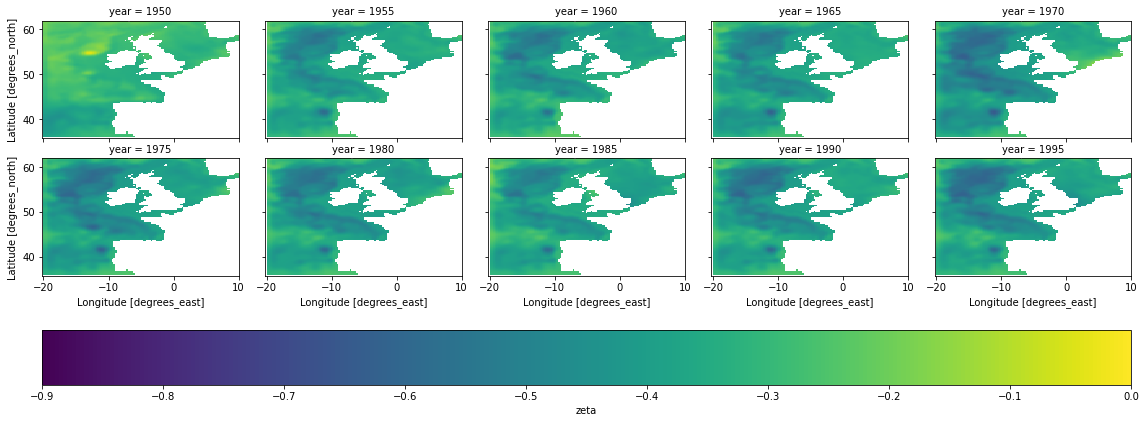

In [60]:
years = range(1950, 2000, 5)
roms_output_northsea.sel(year = years).zeta.plot(col = 'year', col_wrap = 5, cbar_kwargs={'orientation': 'horizontal'}, vmin = -0.9, vmax = 0)

Plot of zeta resulting from the 1/4° ROMS run. What is the unit of zeta? I guess its meters. 

Apparently zeta only has negative values, that seems strange but might be different for MDT w.r.t. area-weighted regional mean

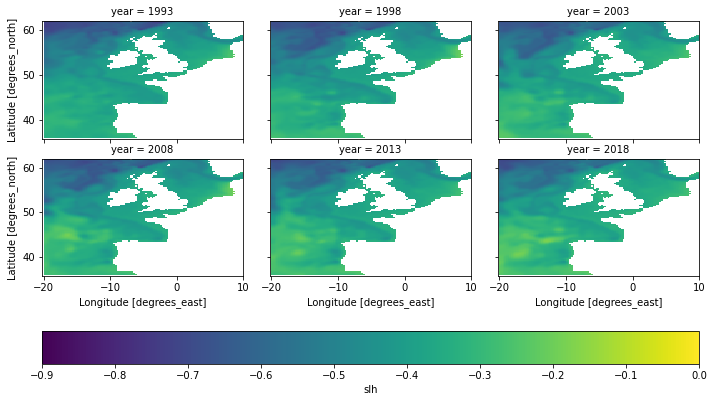

In [61]:
years = range(1993, 2020, 5)
roms_output_northsea_tim.sel(year = years).slh.plot(col = 'year', col_wrap = 3, cbar_kwargs={'orientation': 'horizontal'}, vmin = -0.9, vmax = 0)

Plot of slh resulting from 1/8° ROMS run performed by Tim. Also here values are only negative.

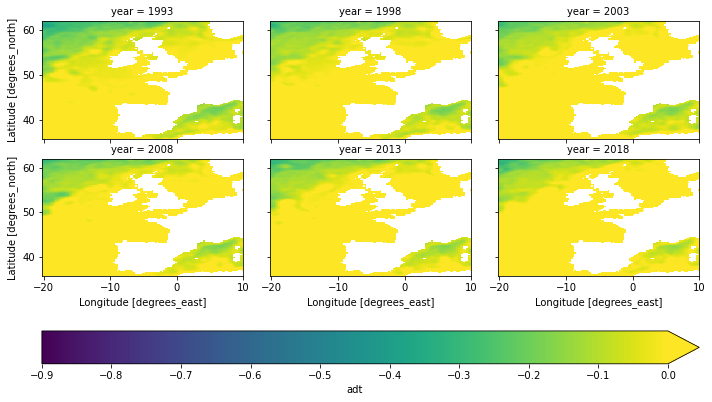

In [62]:
aviso_altimetry.sel(year = years).adt.plot(col = 'year', col_wrap = 3, cbar_kwargs={'orientation': 'horizontal'}, vmin = -0.9, vmax = 0)

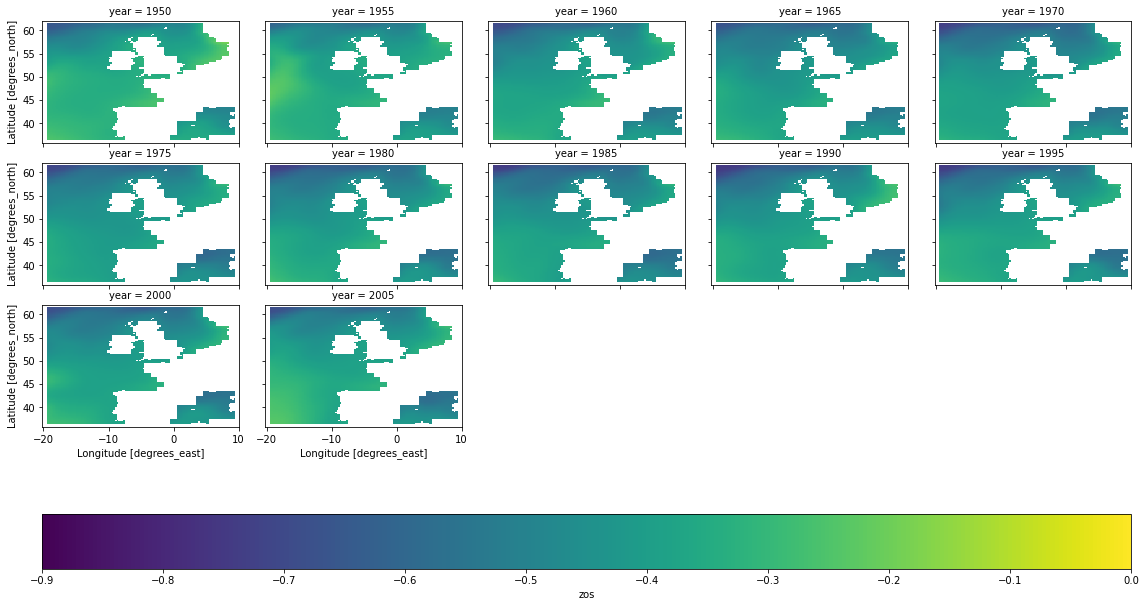

In [63]:
years = range(1950, 2010, 5)
ora20c_rean.sel(year = years).zos.plot(col = 'year', col_wrap = 5, cbar_kwargs={'orientation': 'horizontal'}, vmin = -0.9, vmax = 0)

## Plot maps of SLH for overlapping years 1993 - 1999

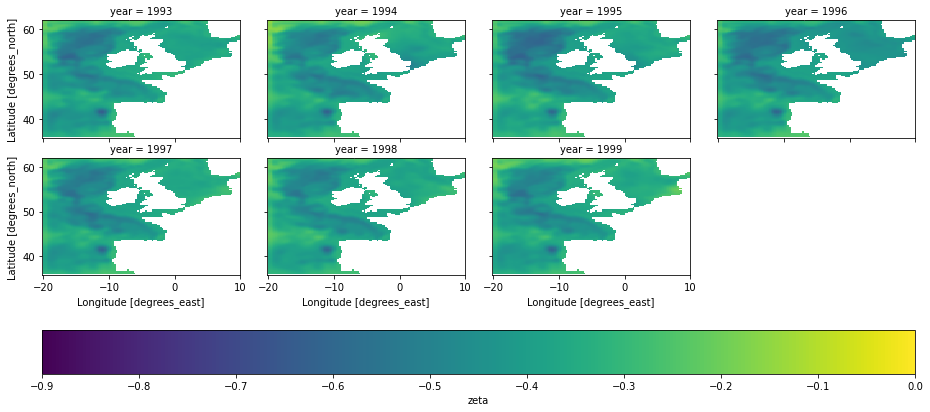

In [64]:
years = range(1993, 2000)
roms_output_northsea.sel(year = years).zeta.plot(col = 'year', col_wrap = 4, cbar_kwargs={'orientation': 'horizontal'}, vmin = -0.9, vmax = 0)

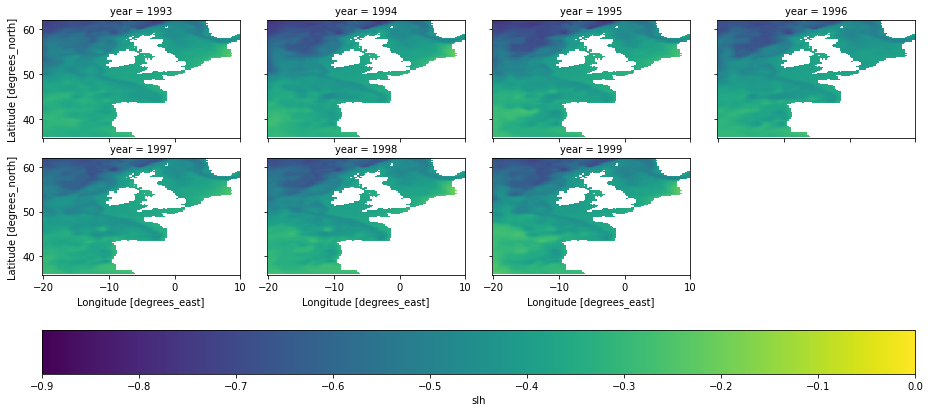

In [65]:
roms_output_northsea_tim.sel(year = years).slh.plot(col = 'year', col_wrap = 4, cbar_kwargs={'orientation': 'horizontal'}, vmin = -0.9, vmax = 0)

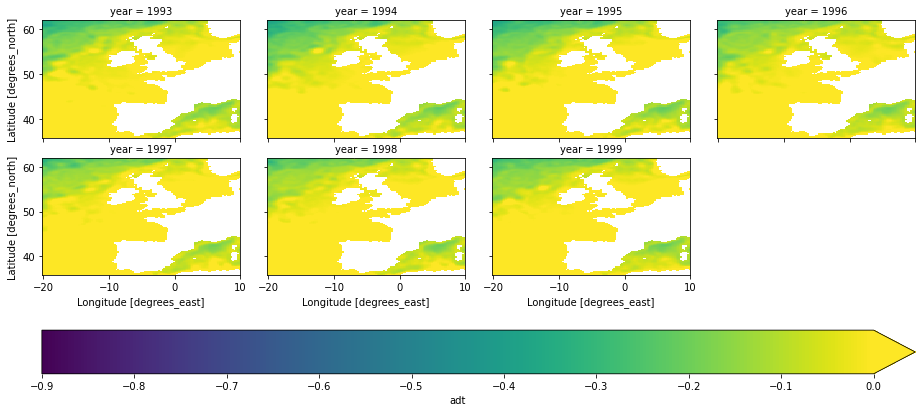

In [66]:
aviso_altimetry.sel(year = years).adt.plot(col = 'year', col_wrap = 4, cbar_kwargs={'orientation': 'horizontal'}, vmin = -0.9, vmax = 0)

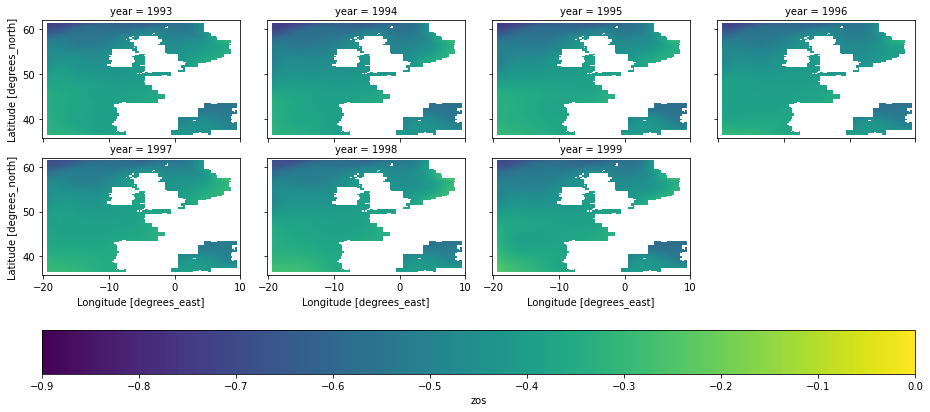

In [67]:
ora20c_rean.sel(year = years).zos.plot(col = 'year', col_wrap = 4, cbar_kwargs={'orientation': 'horizontal'}, vmin = -0.9, vmax = 0)

## Plot SLH for some locations along the Dutch coast

Something I should figure out to do is convert ROMS grid data back to lat lon values

In [68]:
def station_coords(): 
    """
    Function to obtain the coordinates of the tide gauge stations as a dataframe
    
    """
    path_slh = '/Users/iriskeizer/Documents/Wind effect/Data/observations/SLH/'
    stations = ['Vlissingen', 'Hoek v. Holland', 'Den Helder', 'Delfzijl', 'Harlingen', 'IJmuiden']
    
    # Necessary declarations to obtain tide gauge station coordinates
    path_locations = path_slh + 'rlr_annual/filelist.txt'
    loc_num = [20, 22, 23, 24, 25, 32]
    col_names = ['id', 'lat', 'lon', 'station', 'coastline_code', 'station_code', 'quality']
    
    # Create dataframe
    df = pd.read_csv(path_locations, sep=';', header=None, names=col_names)
    df = df.set_index('id')
    df = df.loc[loc_num, :]
    df['station'] = stations
    df = df.set_index('station')
    df = df.drop(['coastline_code', 'station_code', 'quality'], axis=1)
    
    return df

tg_coords = station_coords()

In [69]:
tg_coords

,lat,lon
station,,
Vlissingen,51.442222,3.596111
Hoek v. Holland,51.977500,4.120000
Den Helder,52.964444,4.745000
Delfzijl,53.326389,6.933056
Harlingen,53.175556,5.409444
IJmuiden,52.462222,4.554722


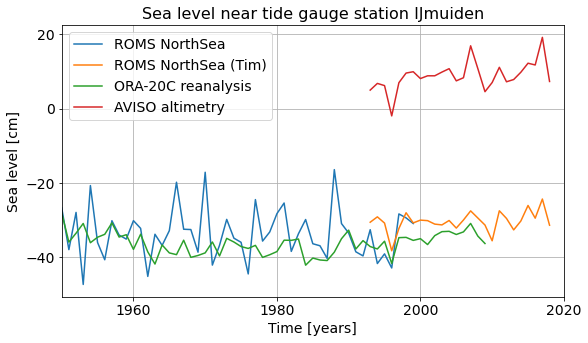

In [70]:
station = 'IJmuiden'  # When station is changed for some datasets the values should be changed to move more towards the sea to not get NaN values

plt.figure(figsize = (9,5))


# Select data near station
roms_output_northsea_station = roms_output_northsea.sel(lat = tg_coords['lat'][station], lon = tg_coords['lon'][station]-0.4, method = 'Nearest')
roms_output_northsea_tim_station = roms_output_northsea_tim.sel(lat = tg_coords['lat'][station], lon = tg_coords['lon'][station]-0.5, method = 'Nearest')
ora20c_rean_station = ora20c_rean.sel(lat = tg_coords['lat'][station], lon = tg_coords['lon'][station]-1.06, method = 'Nearest')
aviso_altimetry_station = aviso_altimetry.sel(lat = tg_coords['lat'][station], lon = tg_coords['lon'][station]-0.1, method = 'Nearest')


# Plot data
plt.plot(roms_output_northsea_station.year, roms_output_northsea_station.zeta*100)
plt.plot(roms_output_northsea_tim_station.year, roms_output_northsea_tim_station.slh*100)
plt.plot(ora20c_rean_station.year, ora20c_rean_station.zos.values*100)
plt.plot(aviso_altimetry_station.year, aviso_altimetry_station.adt.values*100)


# Format figure
fsize = 14

plt.xlabel('Time [years]', fontsize = fsize)
plt.ylabel('Sea level [cm]', fontsize = fsize)
plt.title(f'Sea level near tide gauge station {station}', fontsize = fsize + 2)

plt.xlim([1950, 2020])
plt.xticks([1960, 1980, 2000, 2020], fontsize = fsize)
plt.yticks([-40, -20, 0, 20], fontsize = fsize)

plt.grid()


# Add legend
plt.legend(labels = ['ROMS NorthSea', 'ROMS NorthSea (Tim)', 'ORA-20C reanalysis', 'AVISO altimetry'], fontsize = fsize)





In [71]:
roms_output_northsea_station_anom.zeta

<xarray.DataArray 'zeta' (year: 50)>
array([ 0.0687764 , -0.04370287,  0.05631927, -0.13721785,  0.12847346,
       -0.02458504, -0.07090282,  0.03403476, -0.00450769, -0.01537281,
        0.03417015,  0.01346838, -0.11561659, -0.00235173, -0.03230557,
        0.00721237,  0.13740876,  0.01109886,  0.01028568, -0.0505667 ,
        0.16417246, -0.08523312, -0.03197697,  0.03756881, -0.01282942,
       -0.02404612, -0.10896966,  0.09075865, -0.0207037 ,  0.00380203,
        0.05297181,  0.08157822, -0.04839563, -0.00105876,  0.03720552,
       -0.02785748, -0.03329185, -0.06728515,  0.17126611,  0.02628684,
        0.00081196, -0.04953536, -0.06053767,  0.00988221, -0.08104765,
       -0.05502638, -0.09297466,  0.05225632,  0.04166007,  0.02642962],
      dtype=float32)
Coordinates:
    lat      float32 52.38
    lon      float32 4.125
    crs      int32 -2147483647
  * year     (year) int64 1950 1951 1952 1953 1954 ... 1995 1996 1997 1998 1999

In [72]:
roms_output_northsea_tim_station_anom.slh

<xarray.DataArray 'slh' (year: 26)>
array([-0.0020518 ,  0.0124048 , -0.00437972, -0.07877278, -0.01889941,
        0.02341655, -0.0038462 ,  0.00362796,  0.00221583, -0.0071156 ,
       -0.00922421,  0.00259548, -0.01775151,  0.0039286 ,  0.02844527,
        0.00939968, -0.00960574, -0.05190656,  0.02873772,  0.00811473,
       -0.02263442,  0.00126949,  0.04295802,  0.00888294,  0.06028429,
       -0.01009414], dtype=float32)
Coordinates:
  * year     (year) int64 1993 1994 1995 1996 1997 ... 2014 2015 2016 2017 2018
    lat      float32 52.38
    lon      float32 4.125
    crs      int32 -2147483647

In [73]:
xr.corr(roms_output_northsea_station_anom.zeta, roms_output_northsea_tim_station_anom.slh).values

array(0.4490153)

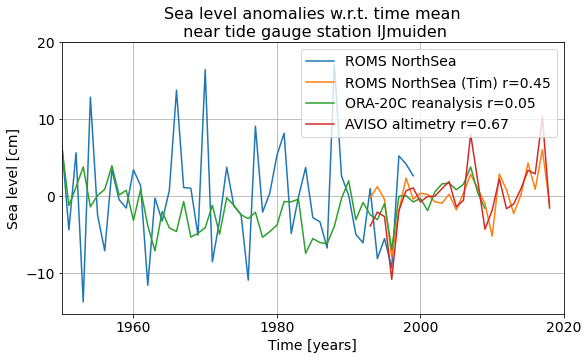

In [74]:
plt.figure(figsize = (9,5))

# Subtract time mean
roms_output_northsea_station_anom = roms_output_northsea_station - roms_output_northsea_station.mean()
roms_output_northsea_tim_station_anom = roms_output_northsea_tim_station - roms_output_northsea_tim_station.mean()
ora20c_rean_station_anom = ora20c_rean_station - ora20c_rean_station.mean()
aviso_altimetry_station_anom = aviso_altimetry_station - aviso_altimetry_station.mean()




# Plot data
plt.plot(roms_output_northsea_station_anom.year, roms_output_northsea_station_anom.zeta*100)
plt.plot(roms_output_northsea_tim_station_anom.year, roms_output_northsea_tim_station_anom.slh*100)
plt.plot(ora20c_rean_station_anom.year, ora20c_rean_station_anom.zos.values*100)
plt.plot(aviso_altimetry_station_anom.year, aviso_altimetry_station_anom.adt.values*100)


# Format figure
fsize = 14

plt.xlabel('Time [years]', fontsize = fsize)
plt.ylabel('Sea level [cm]', fontsize = fsize)
plt.title(f'Sea level anomalies w.r.t. time mean\n near tide gauge station {station}', fontsize = fsize + 2)

plt.xlim([1950, 2020])
plt.xticks([1960, 1980, 2000, 2020], fontsize = fsize)
plt.yticks([-10, 0, 10, 20], fontsize = fsize)

plt.grid()

r_roms_tim = xr.corr(roms_output_northsea_station_anom.zeta, roms_output_northsea_tim_station_anom.slh).values.round(2)
r_ora = xr.corr(roms_output_northsea_station_anom.zeta, ora20c_rean_station_anom.zos).values.round(2)
r_aviso = xr.corr(roms_output_northsea_station_anom.zeta, aviso_altimetry_station_anom.adt).values.round(2)

label1 = 'ROMS NorthSea'
label2 = f'ROMS NorthSea (Tim) r={r_roms_tim}'
label3 = f'ORA-20C reanalysis r={r_ora}'
label4 = f'AVISO altimetry r={r_aviso}'

# Add legend
plt.legend(labels = [label1, label2, label3, label4], fontsize = fsize)





## Plot MDT anomalies w.r.t. area-weighted regional mean

Actually, for good comparison, all data fields should be interpolated to the ROMS 1/4° grid

In [77]:
# Select data from 1993 - 1999 and obtain time average to get MDT
roms_output_northsea_mdt = roms_output_northsea.zeta.where((roms_output_northsea.year > 1992) & (roms_output_northsea.year < 2013), drop = True).mean('year')


# Obtain anomaly w.r.t. area-weighted regional mean
weights = np.cos(np.deg2rad(roms_output_northsea_mdt.lat))
data_weighted = roms_output_northsea_mdt.weighted(weights)
roms_output_northsea_area_mean = data_weighted.mean(dim = ['lat', 'lon'])
roms_output_northsea_mdt_anomaly = roms_output_northsea_mdt - roms_output_northsea_area_mean



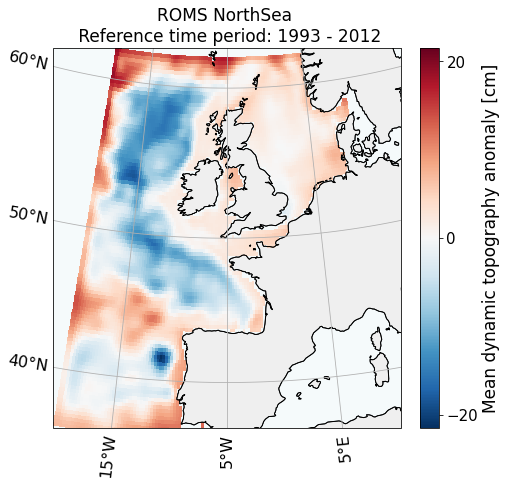

In [78]:
# Create plot for roms_output_tim_northsea8

plt.figure(figsize = (7,7))
fsize = 14

ax = plt.axes(projection=ccrs.LambertConformal(central_longitude = -5, central_latitude = 49))
ax.coastlines()
roms_output_northsea_mdt_anomaly_cm = roms_output_northsea_mdt_anomaly*100
plot = roms_output_northsea_mdt_anomaly_cm.plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False)
    
cb = plt.colorbar(plot, orientation = 'vertical', fraction = 0.05, ticks = [-20, 0, 20])                                   
cb.set_label(label = 'Mean dynamic topography anomaly [cm]', size = fsize+3)
cb.ax.tick_params(labelsize = fsize+1)                      
    
ax.set_title('ROMS NorthSea \n Reference time period: 1993 - 2012', fontsize = fsize+3)
ax.add_feature(cf.LAND, color = 'silver', alpha = 0.25)
ax.add_feature(cf.OCEAN, color='lightblue', alpha = 0.12)
ax.coastlines(resolution = '50m', linewidth=.7, color = 'k')
ax.set_extent([-20, 10, 36, 62], crs=ccrs.PlateCarree())
    
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels = True)
gl.top_labels = False
gl.x_inline = False
gl.right_labels = False
gl.xlabel_style = {'size': fsize+2}
gl.ylabel_style = {'size': fsize+2}
gl.ylocator = mticker.FixedLocator([40, 50, 60])
gl.xlocator = mticker.FixedLocator([-15, -5, 5])

In [75]:
# Obtain anomaly w.r.t. area-weighted regional mean
weights = np.cos(np.deg2rad(cnes_mdt.lat))
data_weighted = cnes_mdt.weighted(weights)
cnes_mdt_area_mean = data_weighted.mean(dim = ['lat', 'lon'])
cnes_mdt_anomaly = cnes_mdt - cnes_mdt_area_mean

Text(-0.8, 46.7, 'PCC = 0')

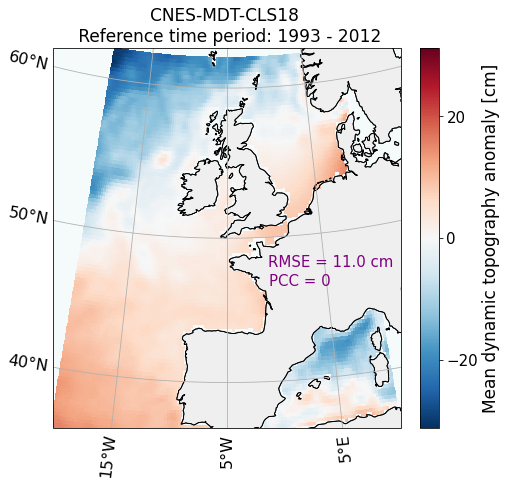

In [122]:

plt.figure(figsize = (7,7))
fsize = 14

ax = plt.axes(projection=ccrs.LambertConformal(central_longitude = -5, central_latitude = 49))
ax.coastlines()
cnes_mdt_anomaly_cm = cnes_mdt_anomaly.mdt*100
plot = cnes_mdt_anomaly_cm.plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False)
    
cb = plt.colorbar(plot, orientation = 'vertical', fraction = 0.05, ticks = [-20, 0, 20])                                   
cb.set_label(label = 'Mean dynamic topography anomaly [cm]', size = fsize+3)
cb.ax.tick_params(labelsize = fsize+1)                      
    
ax.set_title('CNES-MDT-CLS18 \n Reference time period: 1993 - 2012', fontsize = fsize+3)
ax.add_feature(cf.LAND, color = 'silver', alpha = 0.25)
ax.add_feature(cf.OCEAN, color='lightblue', alpha = 0.12)
ax.coastlines(resolution = '50m', linewidth=.7, color = 'k')
ax.set_extent([-20, 10, 36, 62], crs=ccrs.PlateCarree())
    
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels = True)
gl.top_labels = False
gl.x_inline = False
gl.right_labels = False
gl.xlabel_style = {'size': fsize+2}
gl.ylabel_style = {'size': fsize+2}
gl.ylocator = mticker.FixedLocator([40, 50, 60])
gl.xlocator = mticker.FixedLocator([-15, -5, 5])

rmse = xs.rmse(roms_output_northsea_mdt_anomaly, cnes_mdt_anomaly.mdt, dim = ['lat', 'lon'], skipna = True).values[0]


plt.text(-0.8, 48, f'RMSE = {rmse.round(2)*100} cm',transform=ccrs.PlateCarree(), fontsize = fsize+1, color = 'purple')
plt.text(-0.8, 46.7, f'PCC = {0}',transform=ccrs.PlateCarree(), fontsize = fsize+1, color = 'purple')

In [95]:
rmse

<xarray.DataArray (time: 1)>
array([0.11257676])
Coordinates:
    crs      int32 -2147483647
  * time     (time) datetime64[ns] 1950-01-01

In [93]:
roms_output_northsea_mdt_anomaly

<xarray.DataArray 'zeta' (lat: 105, lon: 121)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan, 0.07003291, 0.06996713, ...,        nan,        nan,
               nan],
       [       nan, 0.06842564, 0.06832985, ...,        nan,        nan,
               nan],
       ...,
       [       nan, 0.16582326, 0.16484051, ...,        nan,        nan,
               nan],
       [       nan, 0.17932173, 0.17869551, ...,        nan,        nan,
               nan],
       [       nan, 0.18715454, 0.18673808, ...,        nan,        nan,
               nan]])
Coordinates:
  * lat      (lat) float32 35.88 36.12 36.38 36.62 ... 61.12 61.38 61.62 61.88
  * lon      (lon) float32 -20.12 -19.88 -19.62 -19.38 ... 9.375 9.625 9.875
    crs      int32 -2147483647

I also have to obtain the anomaly w.r.t. area-weighted regional mean for CNES-MDT-CLS18

In [79]:
# Select data from 1993 - 2012 and obtain time average to get MDT
roms_output_northsea_tim_mdt = roms_output_northsea_tim.slh.where((roms_output_northsea_tim.year > 1992) & (roms_output_northsea_tim.year < 2013), drop = True).mean('year')


# Obtain anomaly w.r.t. area-weighted regional mean
weights = np.cos(np.deg2rad(roms_output_northsea_tim_mdt.lat))
data_weighted = roms_output_northsea_tim_mdt.weighted(weights)

roms_output_northsea_tim_mdt_area_mean = data_weighted.mean(dim = ['lat', 'lon'])
roms_output_northsea_tim_mdt_anomaly = roms_output_northsea_tim_mdt - roms_output_northsea_tim_mdt_area_mean


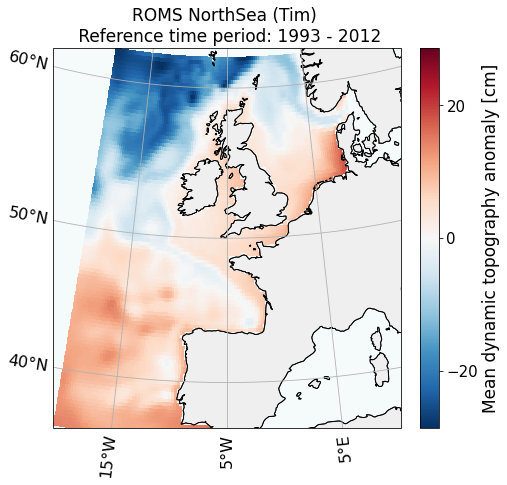

In [80]:
# Create plot for roms_output_tim_northsea8

plt.figure(figsize = (7,7))
fsize = 14

ax = plt.axes(projection=ccrs.LambertConformal(central_longitude = -5, central_latitude = 49))
ax.coastlines()
roms_output_northsea_tim_mdt_anomaly_cm = roms_output_northsea_tim_mdt_anomaly*100
plot = roms_output_northsea_tim_mdt_anomaly_cm.plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False)
    
cb = plt.colorbar(plot, orientation = 'vertical', fraction = 0.05, ticks = [-20, 0, 20])                                   
cb.set_label(label = 'Mean dynamic topography anomaly [cm]', size = fsize+3)
cb.ax.tick_params(labelsize = fsize+1)                      
    
ax.set_title('ROMS NorthSea (Tim) \n Reference time period: 1993 - 2012', fontsize = fsize+3)
ax.add_feature(cf.LAND, color = 'silver', alpha = 0.25)
ax.add_feature(cf.OCEAN, color='lightblue', alpha = 0.12)
ax.coastlines(resolution = '50m', linewidth=.7, color = 'k')
ax.set_extent([-20, 10, 36, 62], crs=ccrs.PlateCarree())
    
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels = True)
gl.top_labels = False
gl.x_inline = False
gl.right_labels = False
gl.xlabel_style = {'size': fsize+2}
gl.ylabel_style = {'size': fsize+2}
gl.ylocator = mticker.FixedLocator([40, 50, 60])
gl.xlocator = mticker.FixedLocator([-15, -5, 5])

In [81]:
# Select data from 1993 - 2012 and obtain time average to get MDT
ora20c_rean_mdt = ora20c_rean.zos.where((ora20c_rean.year > 1992) & (ora20c_rean.year < 2013), drop = True).mean('year')


# Obtain anomaly w.r.t. area-weighted regional mean
weights = np.cos(np.deg2rad(ora20c_rean_mdt.lat))
data_weighted = ora20c_rean_mdt.weighted(weights)

ora20c_rean_mdt_area_mean = data_weighted.mean(dim = ['lat', 'lon'])
ora20c_rean_mdt_anomaly = ora20c_rean_mdt - ora20c_rean_mdt_area_mean


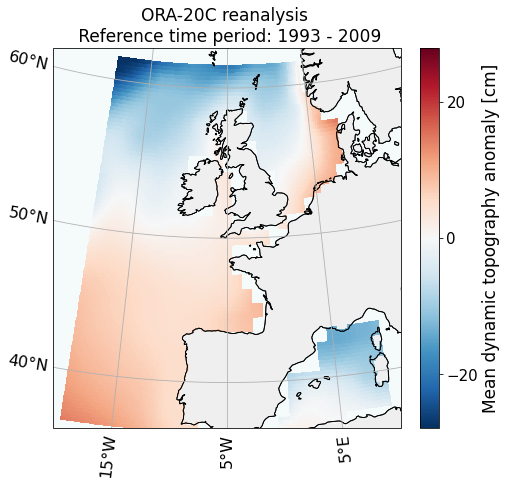

In [82]:
# Create plot for ora20c_rean

plt.figure(figsize = (7,7))
fsize = 14

ax = plt.axes(projection=ccrs.LambertConformal(central_longitude = -5, central_latitude = 49))
ax.coastlines()
ora20c_rean_mdt_anomaly_cm = ora20c_rean_mdt_anomaly*100
plot = ora20c_rean_mdt_anomaly_cm.plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False)
    
cb = plt.colorbar(plot, orientation = 'vertical', fraction = 0.05, ticks = [-20, 0, 20])                                   
cb.set_label(label = 'Mean dynamic topography anomaly [cm]', size = fsize+3)
cb.ax.tick_params(labelsize = fsize+1)                      
    
ax.set_title('ORA-20C reanalysis \n Reference time period: 1993 - 2009', fontsize = fsize+3)
ax.add_feature(cf.LAND, color = 'silver', alpha = 0.25)
ax.add_feature(cf.OCEAN, color='lightblue', alpha = 0.12)
ax.coastlines(resolution = '50m', linewidth=.7, color = 'k')
ax.set_extent([-20, 10, 36, 62], crs=ccrs.PlateCarree())
    
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels = True)
gl.top_labels = False
gl.x_inline = False
gl.right_labels = False
gl.xlabel_style = {'size': fsize+2}
gl.ylabel_style = {'size': fsize+2}
gl.ylocator = mticker.FixedLocator([40, 50, 60])
gl.xlocator = mticker.FixedLocator([-15, -5, 5])

## Plot interannual sea-level variability as standard deviation of detrended, annual mean sea level



In [83]:
# Obtain overlapping period 1993 - 1999
roms_output_northsea_s = roms_output_northsea.where((roms_output_northsea.year > 1992) & (roms_output_northsea.year < 2000), drop = True)

# Obtain detrended data
roms_output_northsea_dt = roms_output_northsea_s.zeta - xr.polyval(roms_output_northsea_s.year, roms_output_northsea_s.zeta.polyfit(dim = 'year', deg = 3).polyfit_coefficients)

# Obtain standard deviation
roms_output_northsea_dt_std = roms_output_northsea_dt.std(dim = ['year'])

/Users/iriskeizer/opt/anaconda3/envs/xesmf/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


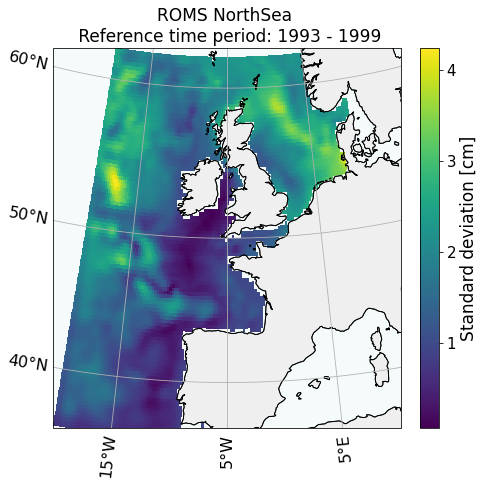

In [84]:
# Create plot for roms_output_northsea4

plt.figure(figsize = (7,7))
fsize = 14

ax = plt.axes(projection=ccrs.LambertConformal(central_longitude = -5, central_latitude = 49))
ax.coastlines()
roms_output_northsea_dt_std_cm = roms_output_northsea_dt_std*100
plot = roms_output_northsea_dt_std_cm.plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False)
    
cb = plt.colorbar(plot, orientation = 'vertical', fraction = 0.05, ticks = [0,1,2,3,4])                                   
cb.set_label(label = 'Standard deviation [cm]', size = fsize+3)
cb.ax.tick_params(labelsize = fsize+1)                      
    
ax.set_title('ROMS NorthSea \n Reference time period: 1993 - 1999', fontsize = fsize+3)
ax.add_feature(cf.LAND, color = 'silver', alpha = 0.25)
ax.add_feature(cf.OCEAN, color='lightblue', alpha = 0.12)
ax.coastlines(resolution = '50m', linewidth=.7, color = 'k')
ax.set_extent([-20, 10, 36, 62], crs=ccrs.PlateCarree())
    
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels = True)
gl.top_labels = False
gl.x_inline = False
gl.right_labels = False
gl.xlabel_style = {'size': fsize+2}
gl.ylabel_style = {'size': fsize+2}
gl.ylocator = mticker.FixedLocator([40, 50, 60])
gl.xlocator = mticker.FixedLocator([-15, -5, 5])

In [85]:
# Obtain overlapping period 1993 - 1999
aviso_altimetry_s = aviso_altimetry.where((aviso_altimetry.year > 1992) & (aviso_altimetry.year < 2000), drop = True)

# Obtain detrended data
aviso_altimetry_dt = aviso_altimetry_s.adt - xr.polyval(aviso_altimetry_s.year, aviso_altimetry_s.adt.polyfit(dim = 'year', deg = 3).polyfit_coefficients)

# Obtain standard deviation
aviso_altimetry_dt_std = aviso_altimetry_dt.std(dim = ['year'])

/Users/iriskeizer/opt/anaconda3/envs/xesmf/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


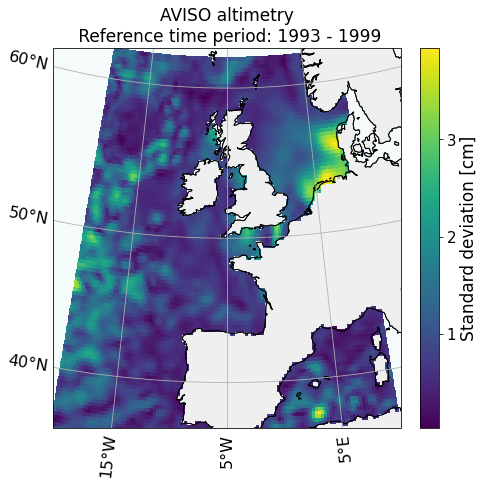

In [86]:
# Create plot for roms_output_northsea4

plt.figure(figsize = (7,7))
fsize = 14

ax = plt.axes(projection=ccrs.LambertConformal(central_longitude = -5, central_latitude = 49))
ax.coastlines()
aviso_altimetry_dt_std_cm = aviso_altimetry_dt_std*100
plot = aviso_altimetry_dt_std_cm.plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False)
    
cb = plt.colorbar(plot, orientation = 'vertical', fraction = 0.05, ticks = [0,1,2,3,4])                                   
cb.set_label(label = 'Standard deviation [cm]', size = fsize+3)
cb.ax.tick_params(labelsize = fsize+1)                      
    
ax.set_title('AVISO altimetry\n Reference time period: 1993 - 1999', fontsize = fsize+3)
ax.add_feature(cf.LAND, color = 'silver', alpha = 0.25)
ax.add_feature(cf.OCEAN, color='lightblue', alpha = 0.12)
ax.coastlines(resolution = '50m', linewidth=.7, color = 'k')
ax.set_extent([-20, 10, 36, 62], crs=ccrs.PlateCarree())
    
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels = True)
gl.top_labels = False
gl.x_inline = False
gl.right_labels = False
gl.xlabel_style = {'size': fsize+2}
gl.ylabel_style = {'size': fsize+2}
gl.ylocator = mticker.FixedLocator([40, 50, 60])
gl.xlocator = mticker.FixedLocator([-15, -5, 5])

In [87]:
# Obtain overlapping period 1993 - 1999
roms_output_northsea_tim_s = roms_output_northsea_tim.where((roms_output_northsea_tim.year > 1992) & (roms_output_northsea_tim.year < 2000), drop = True)

# Obtain detrended data
roms_output_northsea_tim_dt = roms_output_northsea_tim_s.slh - xr.polyval(roms_output_northsea_tim_s.year, roms_output_northsea_tim_s.slh.polyfit(dim = 'year', deg = 3).polyfit_coefficients)

# Obtain standard deviation
roms_output_northsea_tim_dt_std = roms_output_northsea_tim_dt.std(dim = ['year'])

/Users/iriskeizer/opt/anaconda3/envs/xesmf/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


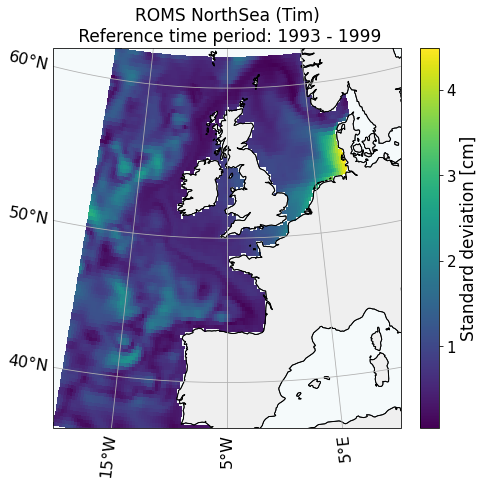

In [88]:
# Create plot for roms_output_northsea4

plt.figure(figsize = (7,7))
fsize = 14

ax = plt.axes(projection=ccrs.LambertConformal(central_longitude = -5, central_latitude = 49))
ax.coastlines()
roms_output_northsea_tim_dt_std_cm = roms_output_northsea_tim_dt_std*100
plot = roms_output_northsea_tim_dt_std_cm.plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False)
    
cb = plt.colorbar(plot, orientation = 'vertical', fraction = 0.05, ticks = [0,1,2,3,4])                                   
cb.set_label(label = 'Standard deviation [cm]', size = fsize+3)
cb.ax.tick_params(labelsize = fsize+1)                      
    
ax.set_title('ROMS NorthSea (Tim)\n Reference time period: 1993 - 1999', fontsize = fsize+3)
ax.add_feature(cf.LAND, color = 'silver', alpha = 0.25)
ax.add_feature(cf.OCEAN, color='lightblue', alpha = 0.12)
ax.coastlines(resolution = '50m', linewidth=.7, color = 'k')
ax.set_extent([-20, 10, 36, 62], crs=ccrs.PlateCarree())
    
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels = True)
gl.top_labels = False
gl.x_inline = False
gl.right_labels = False
gl.xlabel_style = {'size': fsize+2}
gl.ylabel_style = {'size': fsize+2}
gl.ylocator = mticker.FixedLocator([40, 50, 60])
gl.xlocator = mticker.FixedLocator([-15, -5, 5])

In [89]:
# Obtain overlapping period 1993 - 1999
ora20c_rean_s = ora20c_rean.zos.where((ora20c_rean.year > 1992) & (ora20c_rean.year < 2000), drop = True)

# Obtain detrended data
ora20c_rean_dt = ora20c_rean_s - xr.polyval(ora20c_rean_s.year, ora20c_rean_s.polyfit(dim = 'year', deg = 3).polyfit_coefficients)

# Obtain standard deviation
ora20c_rean_dt_std = ora20c_rean_dt.std(dim = ['year'])

/Users/iriskeizer/opt/anaconda3/envs/xesmf/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


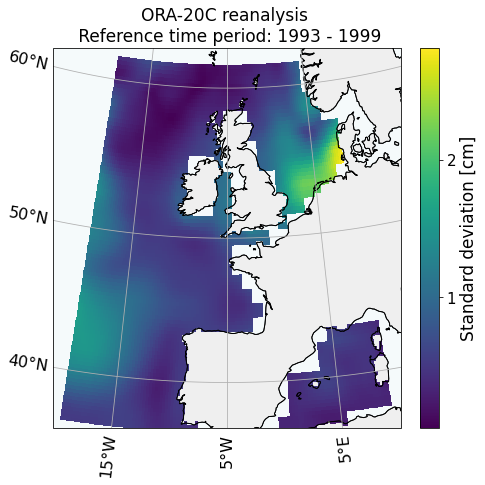

In [90]:
# Create plot for roms_output_northsea4

plt.figure(figsize = (7,7))
fsize = 14

ax = plt.axes(projection=ccrs.LambertConformal(central_longitude = -5, central_latitude = 49))
ax.coastlines()
ora20c_rean_dt_std_cm = ora20c_rean_dt_std*100
plot = ora20c_rean_dt_std_cm.plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False)
    
cb = plt.colorbar(plot, orientation = 'vertical', fraction = 0.05, ticks = [0,1,2,3,4])                                   
cb.set_label(label = 'Standard deviation [cm]', size = fsize+3)
cb.ax.tick_params(labelsize = fsize+1)                      
    
ax.set_title('ORA-20C reanalysis \n Reference time period: 1993 - 1999', fontsize = fsize+3)
ax.add_feature(cf.LAND, color = 'silver', alpha = 0.25)
ax.add_feature(cf.OCEAN, color='lightblue', alpha = 0.12)
ax.coastlines(resolution = '50m', linewidth=.7, color = 'k')
ax.set_extent([-20, 10, 36, 62], crs=ccrs.PlateCarree())
    
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels = True)
gl.top_labels = False
gl.x_inline = False
gl.right_labels = False
gl.xlabel_style = {'size': fsize+2}
gl.ylabel_style = {'size': fsize+2}
gl.ylocator = mticker.FixedLocator([40, 50, 60])
gl.xlocator = mticker.FixedLocator([-15, -5, 5])